In [17]:
import sys

from paths import DATA_DIR, FIG_DIR

import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

from graphvelo.graph_velocity import GraphVelo
from graphvelo.utils import adj_to_knn
import project
from graphvelo.plot import gene_score_histogram

In [19]:
scv.settings.figdir = str(FIG_DIR)
scv.settings.set_figure_params(
    "scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis"
)
scv.settings.plot_prefix = ""

In [21]:
save_figure = True

In [23]:
import cellrank as cr
adata = cr.datasets.bone_marrow()
adata

AnnData object with n_obs × n_vars = 5780 × 27876
    obs: 'clusters', 'palantir_pseudotime', 'palantir_diff_potential'
    var: 'palantir'
    uns: 'clusters_colors', 'palantir_branch_probs_cell_types'
    obsm: 'MAGIC_imputed_data', 'X_tsne', 'palantir_branch_probs'
    layers: 'spliced', 'unspliced'

## Velocity estimation using scvelo

In [26]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=True
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 20068 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [27]:
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata, mode="dynamical")
scv.tl.latent_time(adata)

recovering dynamics (using 16/16 cores)


  0%|          | 0/588 [00:00<?, ?gene/s]

    finished (0:04:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


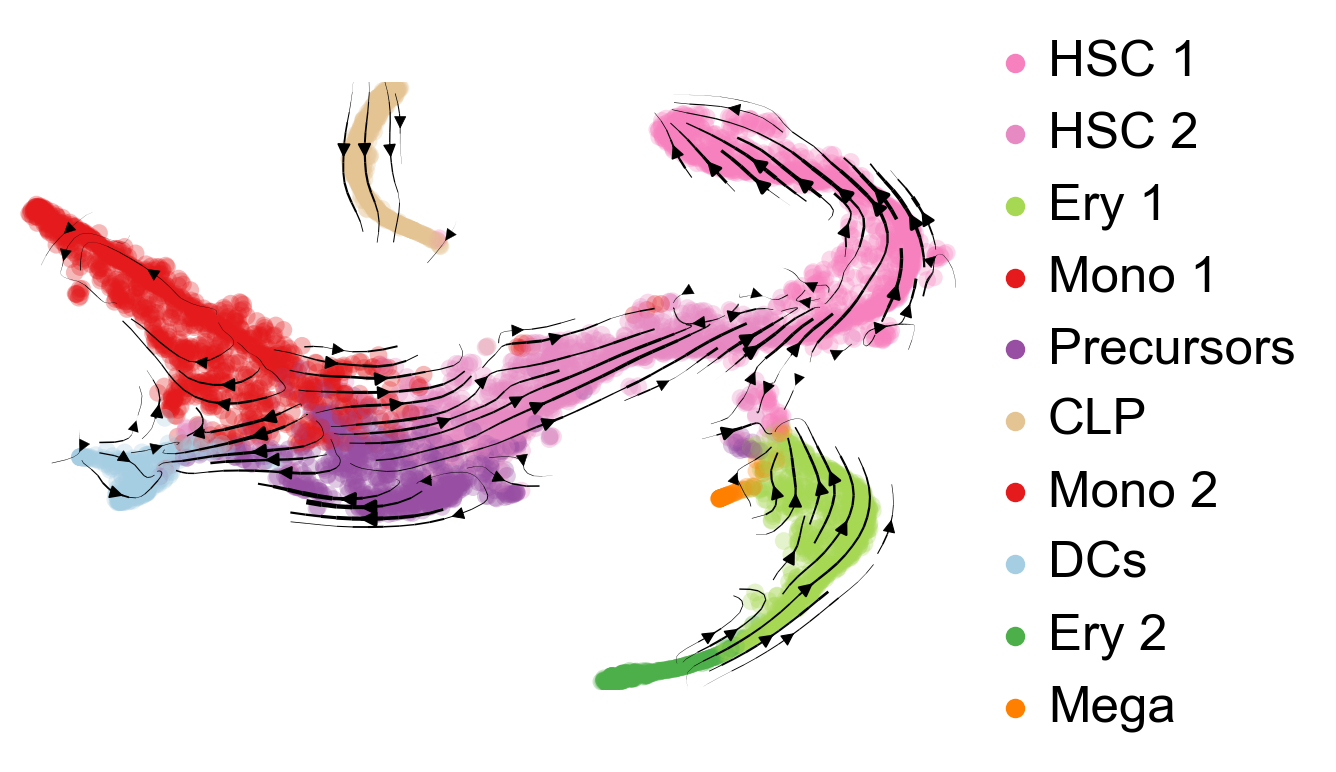

In [28]:
fig_kwargs = {"color": ["clusters"], "legend_loc": "right", "dpi": 100, "title": ""}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/velocities_umap_streamlines.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

check velocity genes with top likelihood in dynamical model.

In [30]:
genes = ["ANGPT1", "RBPMS"]

C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


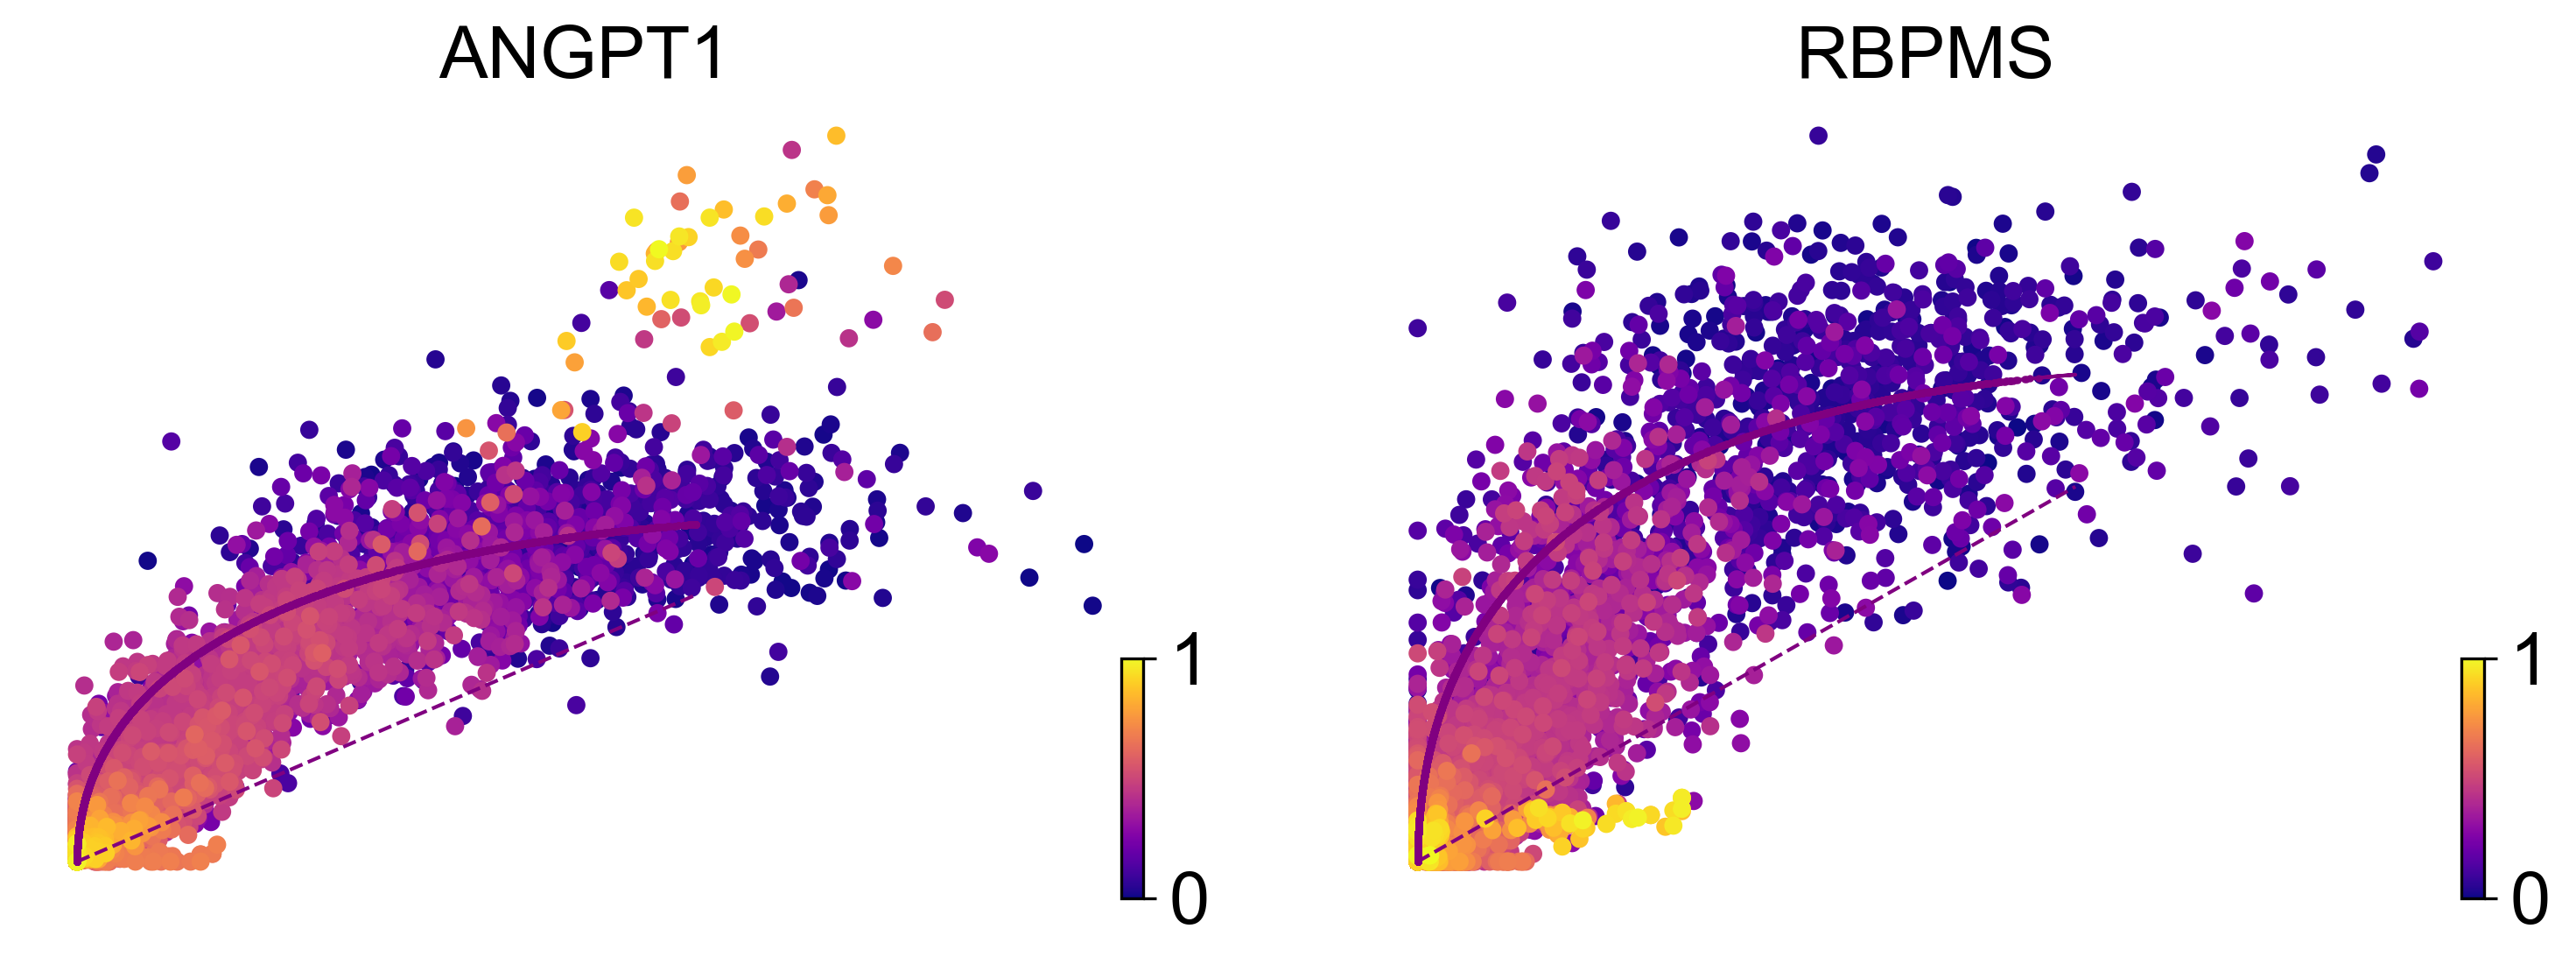

In [31]:
fig_kwargs = {
    "basis": genes,
    "color": "palantir_pseudotime",
    "color_map": "plasma",
    "frameon": False,
    "s": 100,
    "dpi": 150,
}
scv.pl.scatter(adata, **fig_kwargs)

In [32]:
scv.tl.velocity_graph(adata)
scv.tl.velocity_embedding(adata, basis="pca")


computing velocity graph (using 1/16 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


high degration: ANGPT1, NPR3, MSI2
transcription burst: CALR, KLF1, AHSP, NPR3

## Run GraphVelo

In [35]:
indices, _ = adj_to_knn(adata.obsp["connectivities"])
adata.uns["neighbors"]["indices"] = indices

In [36]:
project.gv.mack_score(adata, ekey="Ms", vkey="velocity", tkey="palantir_pseudotime")

197it [00:55,  3.68it/s]Executing <Task pending name='Task-1' coro=<IOPubThread._run_event_pipe_gc() running at C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\ipykernel\iostream.py:122> wait_for=<Future pending cb=[Task.task_wakeup()] created at C:\Users\sleep\anaconda3\Lib\asyncio\base_events.py:448> created at C:\Users\sleep\anaconda3\Lib\asyncio\tasks.py:695> took 0.141 seconds
242it [01:08,  3.50it/s]Executing <Handle IOLoop._run_callback(functools.par...0123AA4A5DA0>)) created at C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\tornado\platform\asyncio.py:241> took 0.109 seconds
588it [02:53,  3.40it/s]


In [37]:
nbrs_idx = adata.uns['neighbors']['indices']

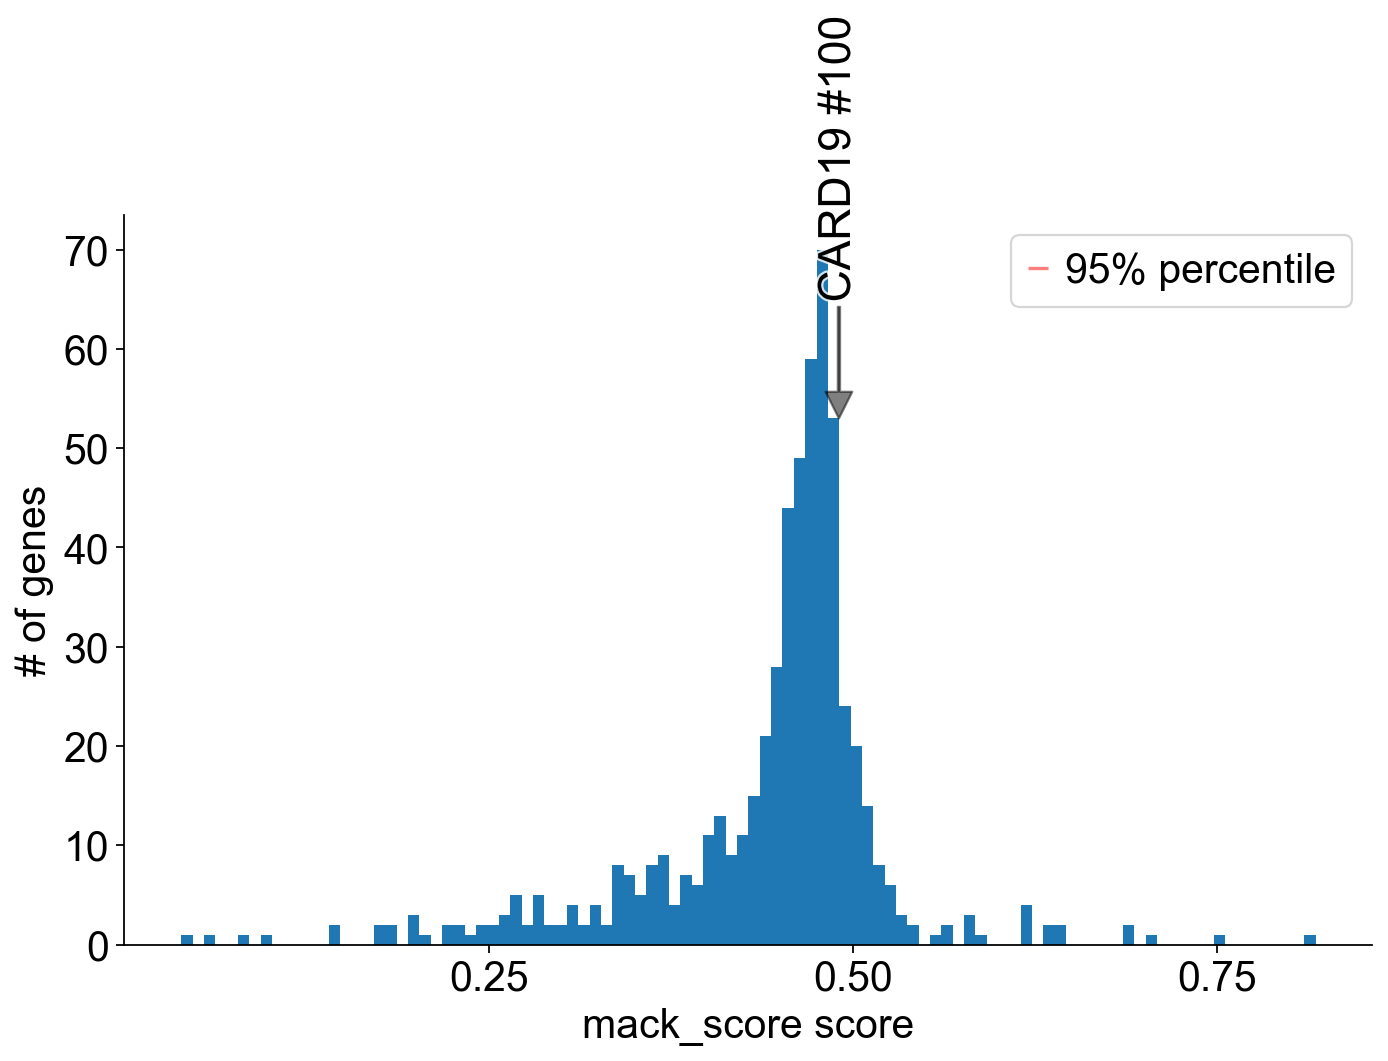

In [38]:
macKG = adata.var["mack_score"].sort_values(ascending=False)[:100].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG[-1]], score_key="mack_score")
plt.show()

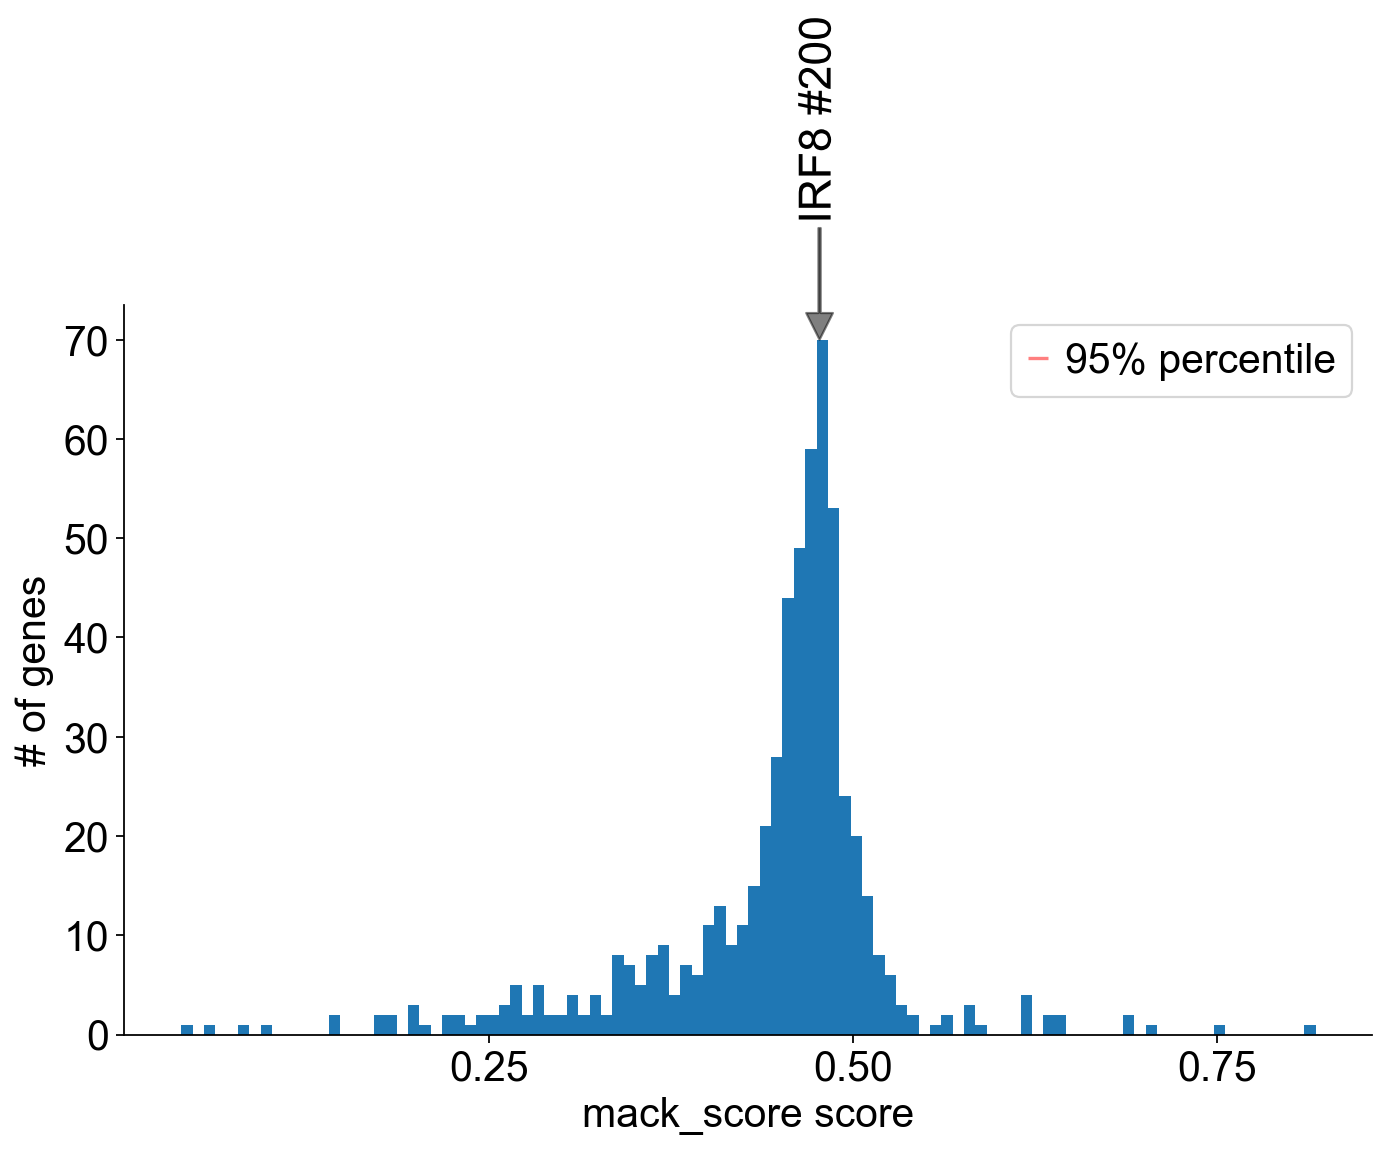

In [39]:
macKG_200 = adata.var["mack_score"].sort_values(ascending=False)[:200].index.to_list()
fig = gene_score_histogram(adata, genes=[macKG_200[-1]], score_key="mack_score")
plt.show()

Learning Phi in tangent space projection.: 100%|█████████████████████████████████████████| 5780/5780 [00:32<00:00, 178.08it/s]
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\graphvelo\graph_velocity.py:373: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(T[T>0])


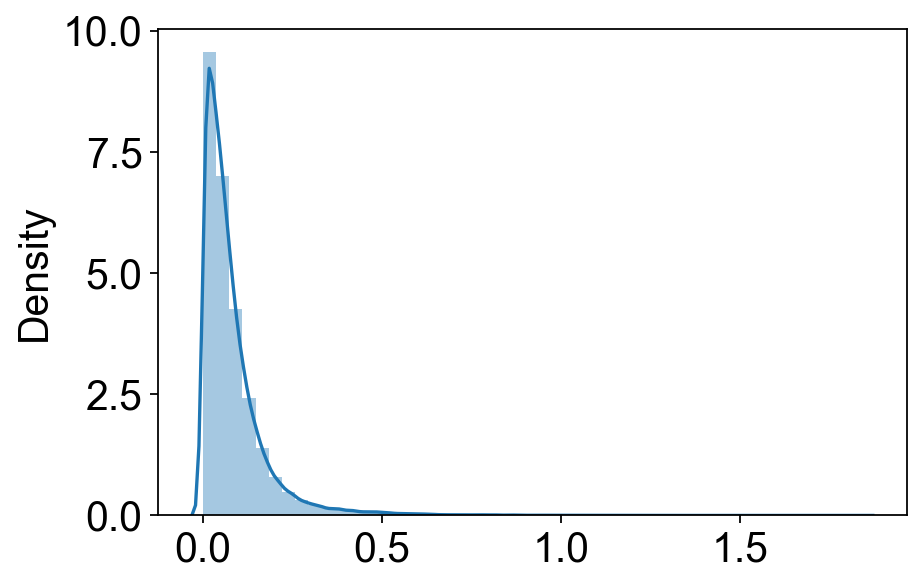

In [40]:
gv = GraphVelo(adata, gene_subset=macKG)
gv.train()
gv.write_to_adata(adata)
gv.plot_phi_dist()

In [41]:
adata.layers["velocity_gvs"] = gv.project_velocity(adata.layers["Ms"])
adata.layers["velocity_gvu"] = gv.project_velocity(adata.layers["Mu"])
adata.obsm["gv_pca"] = gv.project_velocity(adata.obsm["X_pca"])
adata.obsm["gv_tsne"] = gv.project_velocity(adata.obsm["X_tsne"])

projecting velocity vector to low dimensional embedding: 100%|██████████████████████████| 5780/5780 [00:03<00:00, 1714.38it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████████████████████| 5780/5780 [00:03<00:00, 1699.05it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████████████████████| 5780/5780 [00:01<00:00, 4943.85it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████████████████████| 5780/5780 [00:01<00:00, 5304.71it/s]


In [42]:

scvelo_gamma = adata.var['fit_gamma']  # shape: (n_genes,)
print(scvelo_gamma.head())


index
CCNL2          NaN
CDK11A         NaN
NADK      0.213168
CEP104         NaN
RERE           NaN
Name: fit_gamma, dtype: float64


C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\.venv\Lib\site-packages\scvelo\plotting\utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


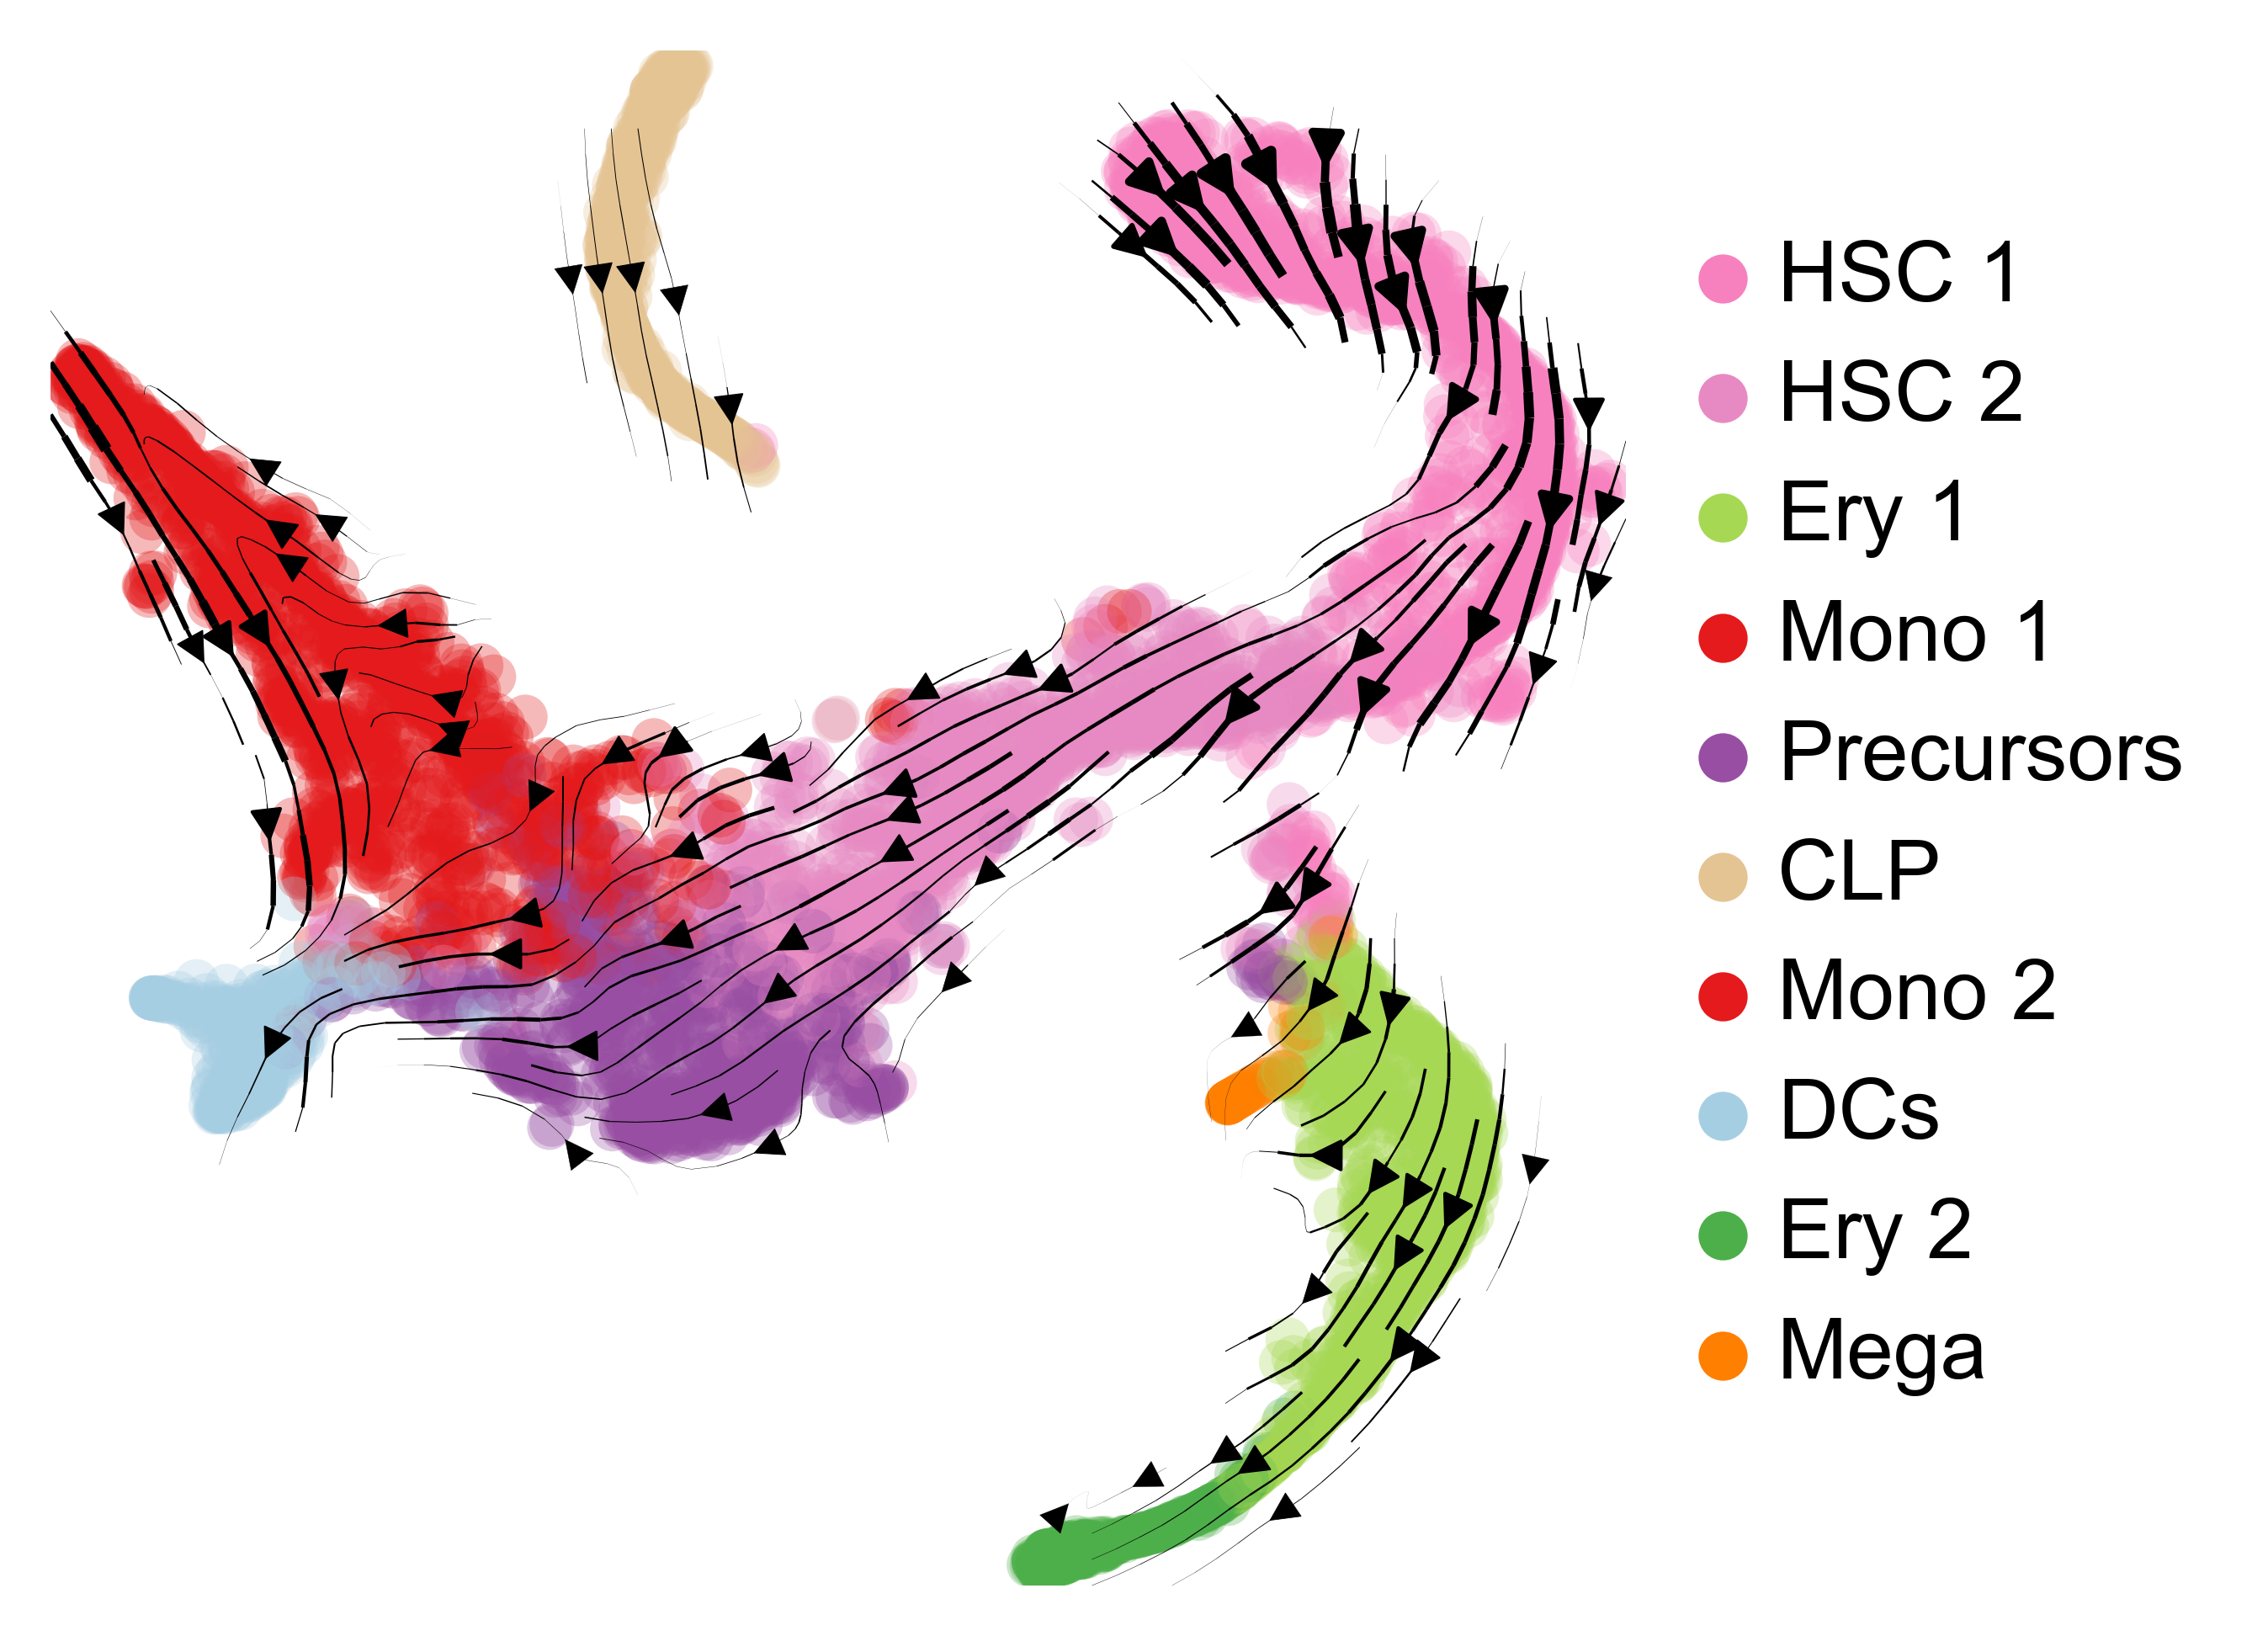

In [43]:
fig_kwargs = {
    "color": ["clusters"],
    "X": adata.obsm["X_tsne"],
    "V": adata.obsm["gv_tsne"],
    "legend_loc": "right",
    "dpi": 300,
    "title": "",
    "legend_fontsize": 12,
    "figsize": (4, 4),
}
# if save_figure: fig_kwargs['save'] = scv.settings.figdir + '/suppl_figures_hspc/gv_result.png'
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

C:\Users\sleep\Desktop\assignment\third\02712\github\02712_group_project\project\plotting\impl.py:116: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  and is_categorical_dtype(adata.obs[color])
Plotting velocity in phase diagram: 100%|███████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


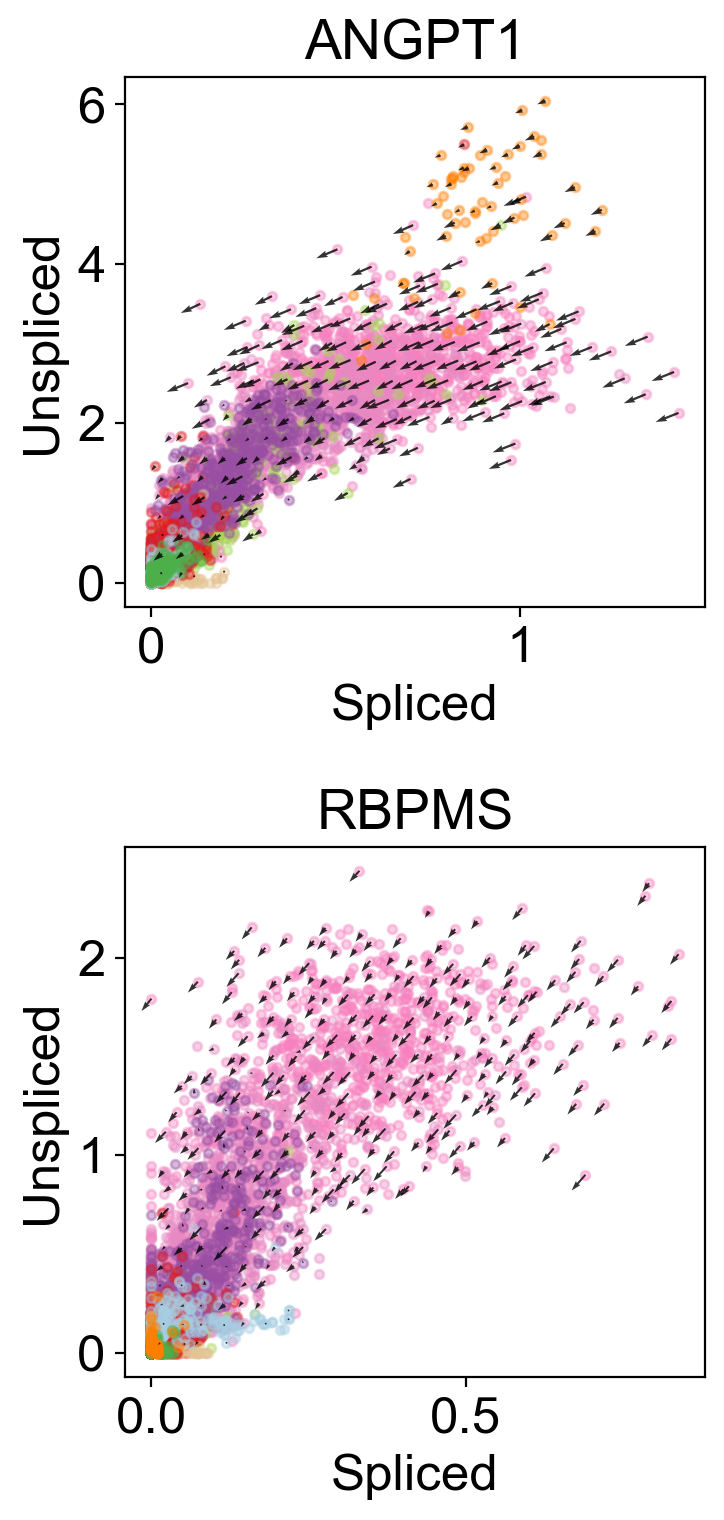

In [44]:
from project.plotting.impl import plot_velocity_phase
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity_gvs",
    "vu_layer": "velocity_gvu",
    "pointsize": 10,
    "ncols": 1,
    "scale": 3,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_mouse_ery/murk_gv100_phase.pdf', dpi=300, transparent=True)
plt.show()

Plotting velocity in phase diagram: 100%|███████████████████████████████████████████████████████| 2/2 [00:05<00:00,  3.00s/it]


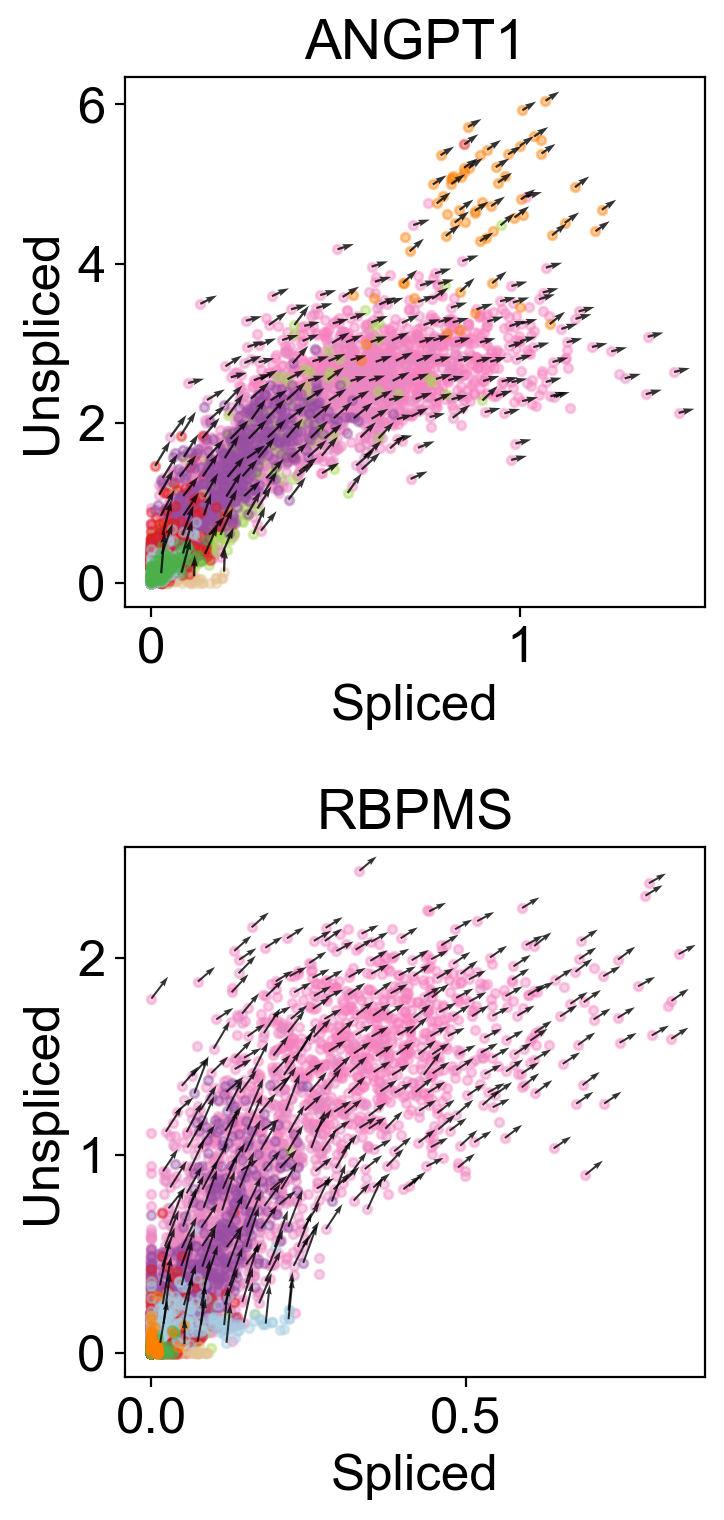

In [45]:
kwargs = {
    "genes": genes,
    "color": "clusters",
    "s_layer": "Ms",
    "u_layer": "Mu",
    "vs_layer": "velocity",
    "vu_layer": "velocity_u",
    "pointsize": 10,
    "ncols": 1,
    "scale": 1,
    "downsample": 0.1,
    "quiver_alpha": 0.8,
    "figsize": (4.2, 8),
    "show": False,
}
ax = plot_velocity_phase(adata, **kwargs)
# plt.savefig(str(FIG_DIR)+'/suppl_figures_hspc/genes_phase_velo.pdf', dpi=300, transparent=True)
plt.show()

In [46]:
adata.write("hspc_gv.h5ad")

In [47]:
# calculate CBC score for both scVelo and GraphVelo with the same transition of HSC -> Ery
from project.graphvelo.metric import cross_boundary_correctness_one_transition
transition = ("HSC_1", "Ery_1")
V_data_scvelo = adata.obsm["velocity_pca"]

cbc_score_sc = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data_scvelo,
    annotation_key="clusters",
    reduce_space_key="X_pca",   # <-- FIXED
    neighbor_key="neighbors"
)

cbc_score_gv = cross_boundary_correctness_one_transition(
    adata,
    transition,
    V_data = adata.obsm["gv_pca"],
    annotation_key="clusters",
    reduce_space_key="X_pca",
    neighbor_key="neighbors"
)

print("CBC score scVelo:", cbc_score_sc)
print("CBC score GraphVelo:", cbc_score_gv)


CBC score scVelo: -0.02072542615503713
CBC score GraphVelo: 0.016594317288943623


In [48]:
# Calculate degradation rates 
from project.graphvelo.metric import calculate_degradation_graphvelo
calculate_degradation_graphvelo(
    adata,
    splice_key="Ms",          # spliced counts
    unsplice_key="Mu",        # unspliced counts
    velocity_key="velocity_gvs",  # GraphVelo spliced velocity
    degradation_key="graphvelo_degradation"
)

scvelo_gamma = adata.var['fit_gamma']  # shape: (n_genes,)
print(scvelo_gamma.head())


index
CCNL2          NaN
CDK11A         NaN
NADK      0.213168
CEP104         NaN
RERE           NaN
Name: fit_gamma, dtype: float64


In [49]:
adata.layers["graphvelo_degradation"]

array([[ 5.79310630e-01,  1.80778715e+00,  3.57221424e-02, ...,
         1.08719503e+01,  7.42734980e+00, -3.03334986e-01],
       [ 7.10086971e-01,  3.43369504e+00,            -inf, ...,
         8.50340760e+00,  6.23049068e-01,  1.25665439e-01],
       [-4.18436475e-02,  1.05043277e+00,  1.56532220e+00, ...,
         3.91394146e+01,             inf,  2.10838500e-01],
       ...,
       [-2.57337285e-02,  8.86722886e-01,  1.76925774e+00, ...,
         1.87454489e+01,  7.84504259e+00,  7.55464285e-01],
       [-7.88065544e-01,  2.89118123e+00,  2.16988795e-01, ...,
         3.62559227e+01,  6.84530664e-01,  1.47601156e+00],
       [ 3.40662174e-01,  3.69409406e+00,  7.48135678e-01, ...,
         6.83813835e+01,  5.10152104e-01,  5.12214584e-01]])

In [ ]:
# jaccbian